In [2]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.5.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 18.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Graph Classification with Graph Neural Networks

[Previous: Node Classification with Graph Neural Networks](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX)

In this tutorial session we will have a closer look at how to apply **Graph Neural Networks (GNNs) to the task of graph classification**.
Graph classification refers to the problem of classifiying entire graphs (in contrast to nodes), given a **dataset of graphs**, based on some structural graph properties.
Here, we want to embed entire graphs, and we want to embed those graphs in such a way so that they are linearly separable given a task at hand.

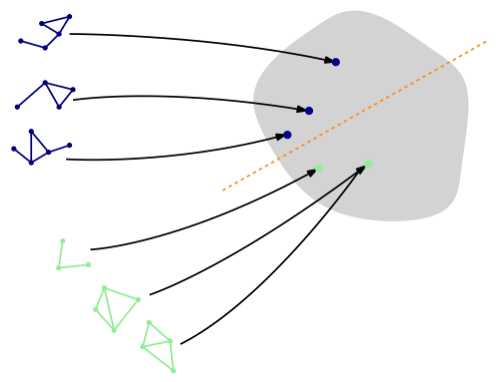

The most common task for graph classification is **molecular property prediction**, in which molecules are represented as graphs, and the task may be to infer whether a molecule inhibits HIV virus replication or not.

The TU Dortmund University has collected a wide range of different graph classification datasets, known as the [**TUDatasets**](https://chrsmrrs.github.io/datasets/), which are also accessible via [`torch_geometric.datasets.TUDataset`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.TUDataset) in PyTorch Geometric.
Let's load and inspect one of the smaller ones, the **MUTAG dataset**:

In [62]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='PROTEINS')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: PROTEINS(1113):
Number of graphs: 1113
Number of features: 3
Number of classes: 2

Data(edge_index=[2, 162], x=[42, 3], y=[1])
Number of nodes: 42
Number of edges: 162
Average node degree: 3.86
Has isolated nodes: False
Has self-loops: False
Is undirected: True


This dataset provides **188 different graphs**, and the task is to classify each graph into **one out of two classes**.

By inspecting the first graph object of the dataset, we can see that it comes with **17 nodes (with 7-dimensional feature vectors)** and **38 edges** (leading to an average node degree of 2.24).
It also comes with exactly **one graph label** (`y=[1]`), and, in addition to previous datasets, provides addtional **4-dimensional edge features** (`edge_attr=[38, 4]`).
However, for the sake of simplicity, we will not make use of those.

PyTorch Geometric provides some useful utilities for working with graph datasets, *e.g.*, we can shuffle the dataset and use the first 150 graphs as training graphs, while using the remaining ones for testing:

In [63]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:887]
test_dataset = dataset[887:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 887
Number of test graphs: 226


In [64]:
#dah preprocessing b augmentation (method ) b3d el splitting
#3mlna 5 types of noiseee
import torch
import random

def add_edge_noise(data, edge_prob=0.05):
    """Randomly adds noise to the edges by adding or deleting edges."""
    edge_index = data.edge_index.clone()
    num_edges = edge_index.size(1)
    num_nodes = data.num_nodes

    # Add random edges
    for _ in range(int(edge_prob * num_edges)):
        u = random.randint(0, num_nodes - 1)
        v = random.randint(0, num_nodes - 1)
        edge_index = torch.cat([edge_index, torch.tensor([[u], [v]])], dim=1)

    # Delete random edges
    for _ in range(int(edge_prob * num_edges)):
        if edge_index.size(1) > 0:
            remove_idx = random.randint(0, edge_index.size(1) - 1)
            edge_index = torch.cat([edge_index[:, :remove_idx], edge_index[:, remove_idx+1:]], dim=1)

    # Return new data object with updated edge_index
    data.edge_index = edge_index
    return data

def add_feature_noise(data, noise_level=0.05):
    """Adds random noise to node features."""
    noise = torch.randn_like(data.x) * noise_level
    data.x = data.x + noise
    return data


def add_feature_dropout(data, dropout_prob=0.1):
    """Randomly drops node features by setting some features to zero."""
    mask = torch.rand_like(data.x) > dropout_prob  # Mask to keep some features
    data.x = data.x * mask  # Apply dropout (zero out some features)
    return data


In [65]:
#APPLYING the augmentation on training only

# Apply data augmentation on the training set
augmented_train_dataset = []

for data in train_dataset:
    # Add edge noise
    data = add_edge_noise(data, edge_prob=0.05)
    # Add feature noise
    data = add_feature_noise(data, noise_level=0.05)

    data = add_feature_dropout(data, dropout_prob=0.1)

    data = add_position_noise(data, noise_level=0.05)

    data = add_edge_weight_noise(data, weight_noise_level=0.05)

    augmented_train_dataset.append(data)


print(f'Number of augmented training graphs: {len(augmented_train_dataset)}')






Number of augmented training graphs: 887


In [34]:
#training on augmnted

train_loader = DataLoader(augmented_train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Train Acc: 0.4002, Test Acc: 0.4204
Epoch: 002, Train Acc: 0.4002, Test Acc: 0.4204
Epoch: 003, Train Acc: 0.4002, Test Acc: 0.4204
Epoch: 004, Train Acc: 0.4002, Test Acc: 0.4204
Epoch: 005, Train Acc: 0.4002, Test Acc: 0.4204
Epoch: 006, Train Acc: 0.4002, Test Acc: 0.4204
Epoch: 007, Train Acc: 0.4002, Test Acc: 0.4204
Epoch: 008, Train Acc: 0.4002, Test Acc: 0.4204
Epoch: 009, Train Acc: 0.4002, Test Acc: 0.4204
Epoch: 010, Train Acc: 0.4002, Test Acc: 0.4204
Epoch: 011, Train Acc: 0.4002, Test Acc: 0.4204
Epoch: 012, Train Acc: 0.4002, Test Acc: 0.4204
Epoch: 013, Train Acc: 0.4002, Test Acc: 0.4204
Epoch: 014, Train Acc: 0.4002, Test Acc: 0.4204
Epoch: 015, Train Acc: 0.4002, Test Acc: 0.4204
Epoch: 016, Train Acc: 0.4002, Test Acc: 0.4204
Epoch: 017, Train Acc: 0.4002, Test Acc: 0.4204
Epoch: 018, Train Acc: 0.4002, Test Acc: 0.4204
Epoch: 019, Train Acc: 0.4002, Test Acc: 0.4204
Epoch: 020, Train Acc: 0.4002, Test Acc: 0.4204
Epoch: 021, Train Acc: 0.4002, Test Acc:

KeyboardInterrupt: 

In [ ]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Lists to store metrics
train_accuracies = []
test_accuracies = []

# Training and Testing functions
def train():
    model.train()
    total_loss = 0  # To record loss

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Forward pass
        loss = criterion(out, data.y)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
        optimizer.zero_grad()  # Clear gradients
        total_loss += loss.item()  # Accumulate loss for plotting

    return total_loss / len(train_loader)  # Return average loss

def test(loader):
    model.eval()
    correct = 0

    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.

    return correct / len(loader.dataset)  # Derive ratio of correct predictions

# Training loop
for epoch in range(1, 171):
    train_loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)

    # Record metrics for plotting
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    # Print epoch metrics
    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Plot the learning curve
plt.figure(figsize=(10, 5))

# Plot accuracy curves
plt.plot(range(1, 171), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, 171), test_accuracies, label='Test Accuracy', color='green')

# Plot settings
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()


## Mini-batching of graphs

Since graphs in graph classification datasets are usually small, a good idea is to **batch the graphs** before inputting them into a Graph Neural Network to guarantee full GPU utilization.
In the image or language domain, this procedure is typically achieved by **rescaling** or **padding** each example into a set of equally-sized shapes, and examples are then grouped in an additional dimension.
The length of this dimension is then equal to the number of examples grouped in a mini-batch and is typically referred to as the `batch_size`.

However, for GNNs the two approaches described above are either not feasible or may result in a lot of unnecessary memory consumption.
Therefore, PyTorch Geometric opts for another approach to achieve parallelization across a number of examples. Here, adjacency matrices are stacked in a diagonal fashion (creating a giant graph that holds multiple isolated subgraphs), and node and target features are simply concatenated in the node dimension:

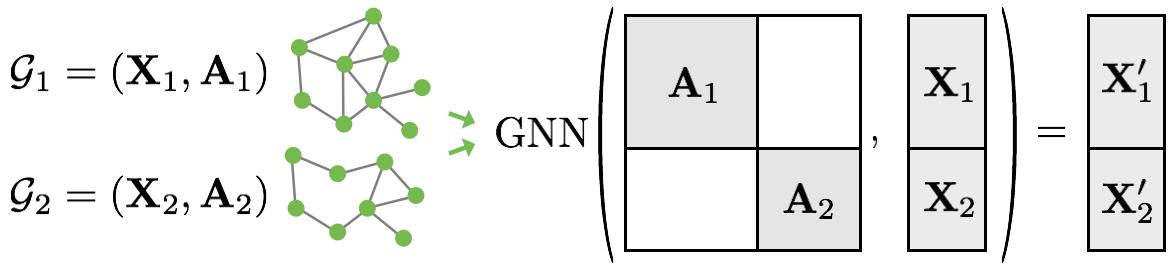

This procedure has some crucial advantages over other batching procedures:

1. GNN operators that rely on a message passing scheme do not need to be modified since messages are not exchanged between two nodes that belong to different graphs.

2. There is no computational or memory overhead since adjacency matrices are saved in a sparse fashion holding only non-zero entries, *i.e.*, the edges.

PyTorch Geometric automatically takes care of **batching multiple graphs into a single giant graph** with the help of the [`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader) class:

In [39]:
# uncommennntt lw 3iznhha mn8eeer augmentation

#from torch_geometric.loader import DataLoader

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# for step, data in enumerate(train_loader):
#     print(f'Step {step + 1}:')
#     print('=======')
#     print(f'Number of graphs in the current batch: {data.num_graphs}')
#     print(data)
#     print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 8680], x=[2374, 3], y=[64], batch=[2374], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 7718], x=[2094, 3], y=[64], batch=[2094], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 10486], x=[2911, 3], y=[64], batch=[2911], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 8604], x=[2418, 3], y=[64], batch=[2418], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 9674], x=[2521, 3], y=[64], batch=[2521], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 10650], x=[2838, 3], y=[64], batch=[2838], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 10590], x=[2792, 3], y=[64], batch=[2792], ptr=[65])

Step 8:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 7094], x=[1885, 3], y=[64]

In [66]:
#dahh nafs el fo2ihhh bs lel augmentedd
#training on augmnted

train_loader = DataLoader(augmented_train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Here, we opt for a `batch_size` of 64, leading to 3 (randomly shuffled) mini-batches, containing all $2 \cdot 64+22 = 150$ graphs.

Furthermore, each `Batch` object is equipped with a **`batch` vector**, which maps each node to its respective graph in the batch:

$$
\textrm{batch} = [ 0, \ldots, 0, 1, \ldots, 1, 2, \ldots ]
$$

## Training a Graph Neural Network (GNN)

Training a GNN for graph classification usually follows a simple recipe:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

There exists multiple **readout layers** in literature, but the most common one is to simply take the average of node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

The final architecture for applying GNNs to the task of graph classification then looks as follows and allows for complete end-to-end training:

In [67]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.6852, Train Acc: 0.5986, Test Acc: 0.5841
Epoch: 002, Loss: 0.6704, Train Acc: 0.5626, Test Acc: 0.5619
Epoch: 003, Loss: 0.6568, Train Acc: 0.6821, Test Acc: 0.6903
Epoch: 004, Loss: 0.6503, Train Acc: 0.6505, Test Acc: 0.6991
Epoch: 005, Loss: 0.6369, Train Acc: 0.6832, Test Acc: 0.6903
Epoch: 006, Loss: 0.6288, Train Acc: 0.6674, Test Acc: 0.6549
Epoch: 007, Loss: 0.6237, Train Acc: 0.6392, Test Acc: 0.6416
Epoch: 008, Loss: 0.6306, Train Acc: 0.6381, Test Acc: 0.6460
Epoch: 009, Loss: 0.6326, Train Acc: 0.7080, Test Acc: 0.7080
Epoch: 010, Loss: 0.6245, Train Acc: 0.6787, Test Acc: 0.6991
Epoch: 011, Loss: 0.6221, Train Acc: 0.6776, Test Acc: 0.7168
Epoch: 012, Loss: 0.6123, Train Acc: 0.6753, Test Acc: 0.6991
Epoch: 013, Loss: 0.6252, Train Acc: 0.6708, Test Acc: 0.6726
Epoch: 014, Loss: 0.6119, Train Acc: 0.7069, Test Acc: 0.7168
Epoch: 015, Loss: 0.6190, Train Acc: 0.6595, Test Acc: 0.6549
Epoch: 016, Loss: 0.6149, Train Acc: 0.7057, Test Acc: 0.7212
Epoch: 0

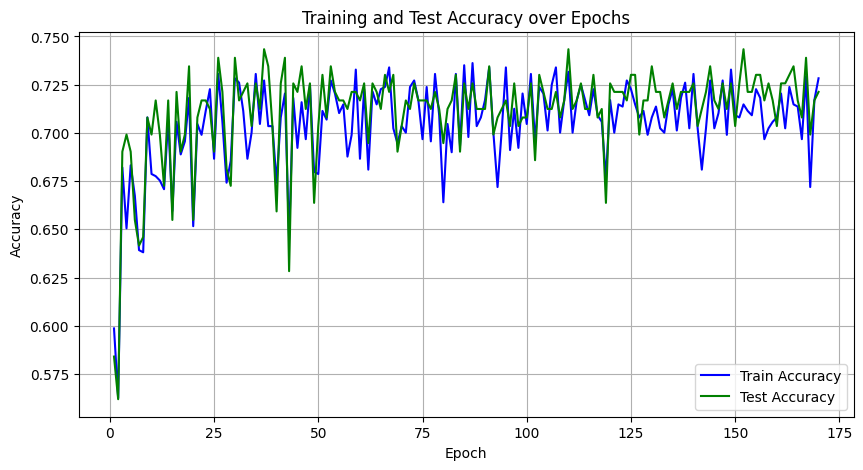

In [28]:
#na el 7ata


import matplotlib.pyplot as plt
from IPython.display import Javascript

# Display adjustment for Colab
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Initialize model, optimizer, and loss criterion
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Lists to store metrics
train_accuracies = []
test_accuracies = []

# Training and Testing functions
def train():
    model.train()
    total_loss = 0  # To record loss

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Forward pass
        loss = criterion(out, data.y)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
        optimizer.zero_grad()  # Clear gradients
        total_loss += loss.item()  # Accumulate loss for plotting

    return total_loss / len(train_loader)  # Return average loss

def test(loader):
    model.eval()
    correct = 0

    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.

    return correct / len(loader.dataset)  # Derive ratio of correct predictions

# Training loop
for epoch in range(1, 171):
    train_loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)

    # Record metrics for plotting
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    # Print epoch metrics
    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Plot the learning curve
plt.figure(figsize=(10, 5))

# Plot accuracy curves
plt.plot(range(1, 171), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, 171), test_accuracies, label='Test Accuracy', color='green')

# Plot settings
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Here, we again make use of the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) with $\mathrm{ReLU}(x) = \max(x, 0)$ activation for obtaining localized node embeddings, before we apply our final classifier on top of a graph readout layer.

Let's train our network for a few epochs to see how well it performs on the training as well as test set:

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.6853, Train Acc: 0.5998, Test Acc: 0.5796
Epoch: 002, Loss: 0.6718, Train Acc: 0.6234, Test Acc: 0.6018
Epoch: 003, Loss: 0.6620, Train Acc: 0.6528, Test Acc: 0.6018
Epoch: 004, Loss: 0.6508, Train Acc: 0.6471, Test Acc: 0.6283
Epoch: 005, Loss: 0.6342, Train Acc: 0.6776, Test Acc: 0.6770
Epoch: 006, Loss: 0.6399, Train Acc: 0.6449, Test Acc: 0.6372
Epoch: 007, Loss: 0.6358, Train Acc: 0.6618, Test Acc: 0.6637
Epoch: 008, Loss: 0.6228, Train Acc: 0.6821, Test Acc: 0.6814
Epoch: 009, Loss: 0.6212, Train Acc: 0.6731, Test Acc: 0.6372
Epoch: 010, Loss: 0.6092, Train Acc: 0.7057, Test Acc: 0.6593
Epoch: 011, Loss: 0.6203, Train Acc: 0.6888, Test Acc: 0.6416
Epoch: 012, Loss: 0.6184, Train Acc: 0.7080, Test Acc: 0.6549
Epoch: 013, Loss: 0.6114, Train Acc: 0.7069, Test Acc: 0.6814
Epoch: 014, Loss: 0.6065, Train Acc: 0.6798, Test Acc: 0.6770
Epoch: 015, Loss: 0.6278, Train Acc: 0.6979, Test Acc: 0.6903
Epoch: 016, Loss: 0.6106, Train Acc: 0.6990, Test Acc: 0.6770
Epoch: 0

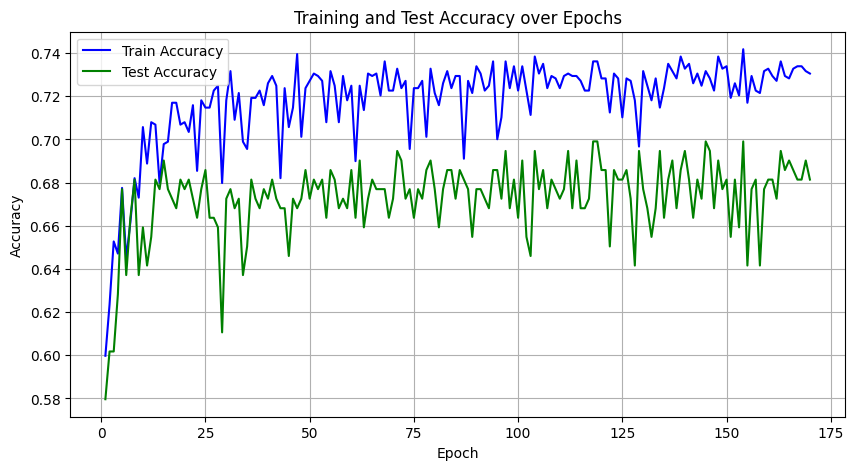

In [49]:
#nafs el fo2o bs na 7tah 3la augmented b train data loader augmented
#na el 7ata


import matplotlib.pyplot as plt
from IPython.display import Javascript

# Display adjustment for Colab
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Initialize model, optimizer, and loss criterion
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Lists to store metrics
train_accuracies = []
test_accuracies = []

# Training and Testing functions
def train():
    model.train()
    total_loss = 0  # To record loss

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Forward pass
        loss = criterion(out, data.y)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
        optimizer.zero_grad()  # Clear gradients
        total_loss += loss.item()  # Accumulate loss for plotting

    return total_loss / len(train_loader)  # Return average loss

def test(loader):
    model.eval()
    correct = 0

    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.

    return correct / len(loader.dataset)  # Derive ratio of correct predictions

# Training loop
for epoch in range(1, 171):
    train_loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)

    # Record metrics for plotting
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    # Print epoch metrics
    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Plot the learning curve
plt.figure(figsize=(10, 5))

# Plot accuracy curves
plt.plot(range(1, 171), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, 171), test_accuracies, label='Test Accuracy', color='green')

# Plot settings
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Epoch: 001, Loss: 0.6867, Train Acc: 0.5998, Test Acc: 0.5796
Epoch: 002, Loss: 0.6701, Train Acc: 0.6257, Test Acc: 0.6372
Epoch: 003, Loss: 0.6601, Train Acc: 0.6539, Test Acc: 0.6460
Epoch: 004, Loss: 0.6487, Train Acc: 0.6404, Test Acc: 0.6283
Epoch: 005, Loss: 0.6345, Train Acc: 0.6719, Test Acc: 0.6681
Epoch: 006, Loss: 0.6389, Train Acc: 0.7012, Test Acc: 0.6858
Epoch: 007, Loss: 0.6472, Train Acc: 0.6178, Test Acc: 0.6239
Epoch: 008, Loss: 0.6269, Train Acc: 0.6922, Test Acc: 0.6858
Epoch: 009, Loss: 0.6212, Train Acc: 0.6967, Test Acc: 0.6903
Epoch: 010, Loss: 0.6130, Train Acc: 0.7057, Test Acc: 0.6637
Epoch: 011, Loss: 0.6191, Train Acc: 0.7001, Test Acc: 0.6681
Epoch: 012, Loss: 0.6167, Train Acc: 0.6922, Test Acc: 0.6549
Epoch: 013, Loss: 0.6128, Train Acc: 0.7125, Test Acc: 0.6903
Epoch: 014, Loss: 0.6110, Train Acc: 0.6933, Test Acc: 0.6903
Epoch: 015, Loss: 0.6220, Train Acc: 0.7215, Test Acc: 0.6814
Epoch: 016, Loss: 0.6138, Train Acc: 0.7148, Test Acc: 0.6814
Epoch: 0

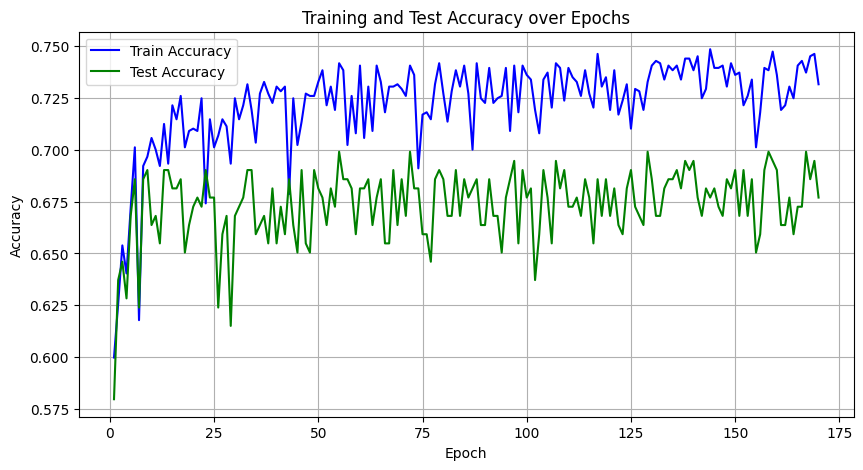

In [68]:
#dah b3d kol el noises el latifa deeh


model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Lists to store metrics
train_accuracies = []
test_accuracies = []

# Training and Testing functions
def train():
    model.train()
    total_loss = 0  # To record loss

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Forward pass
        loss = criterion(out, data.y)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
        optimizer.zero_grad()  # Clear gradients
        total_loss += loss.item()  # Accumulate loss for plotting

    return total_loss / len(train_loader)  # Return average loss

def test(loader):
    model.eval()
    correct = 0

    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.

    return correct / len(loader.dataset)  # Derive ratio of correct predictions

# Training loop
for epoch in range(1, 171):
    train_loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)

    # Record metrics for plotting
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    # Print epoch metrics
    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Plot the learning curve
plt.figure(figsize=(10, 5))

# Plot accuracy curves
plt.plot(range(1, 171), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, 171), test_accuracies, label='Test Accuracy', color='green')

# Plot settings
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()


As one can see, our model reaches around **76% test accuracy**.
Reasons for the fluctations in accuracy can be explained by the rather small dataset (only 38 test graphs), and usually disappear once one applies GNNs to larger datasets.



## (Optional) Exercise

Can we do better than this?
As multiple papers pointed out ([Xu et al. (2018)](https://arxiv.org/abs/1810.00826), [Morris et al. (2018)](https://arxiv.org/abs/1810.02244)), applying **neighborhood normalization decreases the expressivity of GNNs in distinguishing certain graph structures**.
An alternative formulation ([Morris et al. (2018)](https://arxiv.org/abs/1810.02244)) omits neighborhood normalization completely and adds a simple skip-connection to the GNN layer in order to preserve central node information:

$$
\mathbf{x}_v^{(\ell+1)} = \mathbf{W}^{(\ell + 1)}_1 \mathbf{x}_v^{(\ell)} + \mathbf{W}^{(\ell + 1)}_2 \sum_{w \in \mathcal{N}(v)} \mathbf{x}_w^{(\ell)}
$$

This layer is implemented under the name [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv) in PyTorch Geometric.

As an exercise, you are invited to complete the following code to the extent that it makes use of PyG's `GraphConv` rather than `GCNConv`.
This should bring you close to **82% test accuracy**.

In [41]:
#mn awl hna graph conv bdl gcnconv


from torch_geometric.nn import GraphConv


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = ...  # TODO
        self.conv2 = ...  # TODO
        self.conv3 = ...  # TODO
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model2 = GNN(hidden_channels=64)
print(model2)

GNN(
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


Epoch: 001, Loss: 0.7240, Train Acc: 0.6449, Test Acc: 0.5929
Epoch: 002, Loss: 0.6857, Train Acc: 0.6133, Test Acc: 0.5929
Epoch: 003, Loss: 0.6571, Train Acc: 0.6550, Test Acc: 0.6150
Epoch: 004, Loss: 0.6564, Train Acc: 0.6392, Test Acc: 0.6283
Epoch: 005, Loss: 0.6409, Train Acc: 0.6381, Test Acc: 0.6239
Epoch: 006, Loss: 0.6346, Train Acc: 0.6528, Test Acc: 0.6239
Epoch: 007, Loss: 0.6247, Train Acc: 0.7035, Test Acc: 0.6726
Epoch: 008, Loss: 0.6233, Train Acc: 0.7125, Test Acc: 0.6681
Epoch: 009, Loss: 0.6217, Train Acc: 0.6652, Test Acc: 0.6239
Epoch: 010, Loss: 0.6082, Train Acc: 0.6900, Test Acc: 0.6858
Epoch: 011, Loss: 0.6150, Train Acc: 0.7193, Test Acc: 0.6726
Epoch: 012, Loss: 0.6148, Train Acc: 0.7227, Test Acc: 0.6770
Epoch: 013, Loss: 0.6174, Train Acc: 0.6708, Test Acc: 0.6416
Epoch: 014, Loss: 0.6174, Train Acc: 0.6855, Test Acc: 0.6504
Epoch: 015, Loss: 0.6113, Train Acc: 0.6990, Test Acc: 0.6504
Epoch: 016, Loss: 0.6095, Train Acc: 0.7148, Test Acc: 0.6593
Epoch: 0

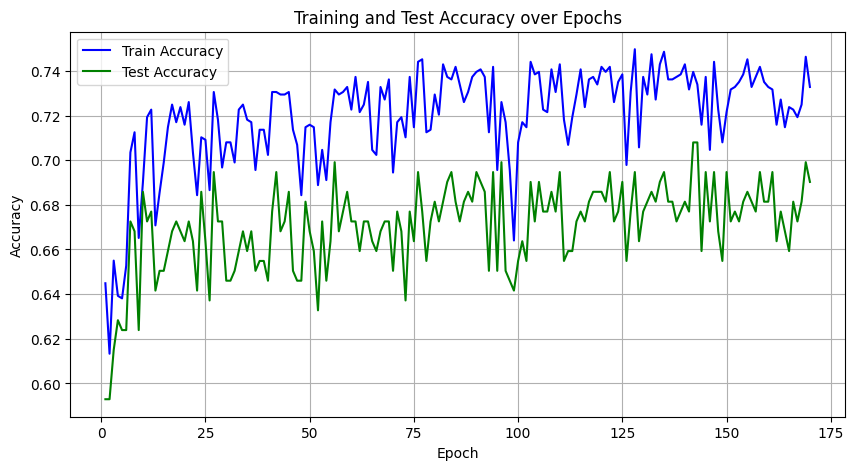

In [42]:
#train 3la gnn w n4of

model2 = GNN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Lists to store metrics
train_accuracies = []
test_accuracies = []

# Training and Testing functions
def train():
    model.train()
    total_loss = 0  # To record loss

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Forward pass
        loss = criterion(out, data.y)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
        optimizer.zero_grad()  # Clear gradients
        total_loss += loss.item()  # Accumulate loss for plotting

    return total_loss / len(train_loader)  # Return average loss

def test(loader):
    model.eval()
    correct = 0

    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.

    return correct / len(loader.dataset)  # Derive ratio of correct predictions

# Training loop
for epoch in range(1, 171):
    train_loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)

    # Record metrics for plotting
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    # Print epoch metrics
    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Plot the learning curve
plt.figure(figsize=(10, 5))

# Plot accuracy curves
plt.plot(range(1, 171), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, 171), test_accuracies, label='Test Accuracy', color='green')

# Plot settings
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GNN(hidden_channels=64)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 201):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

GNN(
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


TypeError: 'ellipsis' object is not callable

In [13]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GraphConv, global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)

        # Define the convolutional layers
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)

        # Define the linear layer for final output
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # First layer
        x = self.conv1(x, edge_index)
        x = x.relu()
        # Second layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        # Third layer
        x = self.conv3(x, edge_index)

        # Apply global pooling
        x = global_mean_pool(x, batch)

        # Dropout and final linear layer
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

# Instantiate the model
model = GNN(hidden_channels=64)
print(model)


GNN(
  (conv1): GraphConv(3, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [14]:
def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients
    out = model(data.x, data.edge_index, data.batch)  # Forward pass
    loss = F.cross_entropy(out, data.y)  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update model weights





    def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


In [16]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GraphConv, global_mean_pool
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
import torch.optim as optim

# Load and prepare dataset
dataset = TUDataset(root='data/TUDataset', name='PROTEINS', transform=NormalizeFeatures())
torch.manual_seed(12345)
dataset = dataset.shuffle()
train_dataset = dataset[:len(dataset) // 10 * 8]
test_dataset = dataset[len(dataset) // 10 * 8:]
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define the GNN model
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

# Initialize model, optimizer, and training components
model = GNN(hidden_channels=64)
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(model)

# Training and evaluation functions
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

# Training loop
for epoch in range(1, 171):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


GNN(
  (conv1): GraphConv(3, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)
Epoch: 001, Loss: 0.9154, Train Acc: 0.5619, Test Acc: 0.5733
Epoch: 002, Loss: 0.6835, Train Acc: 0.5991, Test Acc: 0.5778
Epoch: 003, Loss: 0.6539, Train Acc: 0.6047, Test Acc: 0.5778
Epoch: 004, Loss: 0.6286, Train Acc: 0.6565, Test Acc: 0.5822
Epoch: 005, Loss: 0.6270, Train Acc: 0.6408, Test Acc: 0.5733
Epoch: 006, Loss: 0.6500, Train Acc: 0.5631, Test Acc: 0.5156
Epoch: 007, Loss: 0.6589, Train Acc: 0.6059, Test Acc: 0.5867
Epoch: 008, Loss: 0.6152, Train Acc: 0.7196, Test Acc: 0.6889
Epoch: 009, Loss: 0.6249, Train Acc: 0.6847, Test Acc: 0.6756
Epoch: 010, Loss: 0.6130, Train Acc: 0.7083, Test Acc: 0.6178
Epoch: 011, Loss: 0.6164, Train Acc: 0.6937, Test Acc: 0.6578
Epoch: 012, Loss: 0.6188, Train Acc: 0.6239, Test Acc: 0.5778
Epoch: 013, Loss: 0.6380, Train Acc: 0.7207, Test Acc: 0.6667
Epoch: 014, Loss: 0.6262, Train Acc: 0.715

Epoch: 001, Loss: 0.4681, Train Acc: 0.7782, Test Acc: 0.6800
Epoch: 002, Loss: 0.4840, Train Acc: 0.7973, Test Acc: 0.6800
Epoch: 003, Loss: 0.4705, Train Acc: 0.8007, Test Acc: 0.6667
Epoch: 004, Loss: 0.4708, Train Acc: 0.8052, Test Acc: 0.6756
Epoch: 005, Loss: 0.4626, Train Acc: 0.7995, Test Acc: 0.6889
Epoch: 006, Loss: 0.4531, Train Acc: 0.8074, Test Acc: 0.6622
Epoch: 007, Loss: 0.4601, Train Acc: 0.8007, Test Acc: 0.7022
Epoch: 008, Loss: 0.4730, Train Acc: 0.7984, Test Acc: 0.6622
Epoch: 009, Loss: 0.4622, Train Acc: 0.8131, Test Acc: 0.6889
Epoch: 010, Loss: 0.4459, Train Acc: 0.7883, Test Acc: 0.6978
Epoch: 011, Loss: 0.4519, Train Acc: 0.8142, Test Acc: 0.6533
Epoch: 012, Loss: 0.4485, Train Acc: 0.7995, Test Acc: 0.6711
Epoch: 013, Loss: 0.4759, Train Acc: 0.7736, Test Acc: 0.6756
Epoch: 014, Loss: 0.4674, Train Acc: 0.7995, Test Acc: 0.6711
Epoch: 015, Loss: 0.4569, Train Acc: 0.7669, Test Acc: 0.6533
Epoch: 016, Loss: 0.4565, Train Acc: 0.8007, Test Acc: 0.6800
Epoch: 0

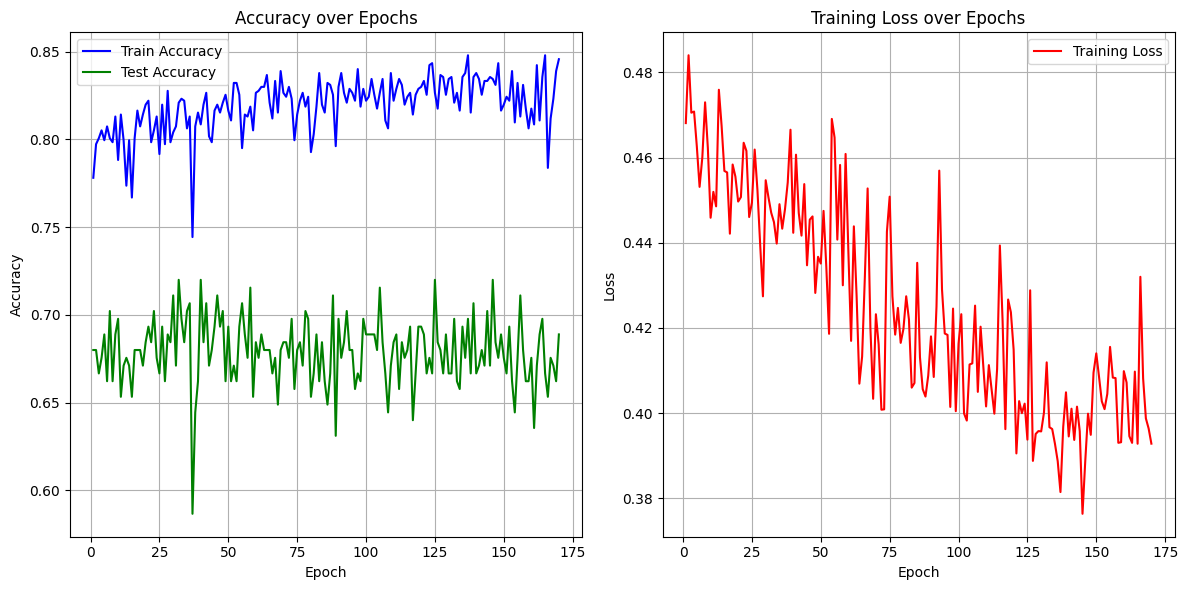

In [18]:
import matplotlib.pyplot as plt

# Lists to store the metrics
train_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(1, 171):
    # Train and record the training loss
    loss = train()
    train_losses.append(loss)

    # Record training and testing accuracy
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    # Print progress
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Plotting the learning curve
plt.figure(figsize=(12, 6))

# Plot training and testing accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, 171), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, 171), test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(range(1, 171), train_losses, label='Training Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


## Conclusion

In this chapter, you have learned how to apply GNNs to the task of graph classification.
You have learned how graphs can be batched together for better GPU utilization, and how to apply readout layers for obtaining graph embeddings rather than node embeddings.

In the next session, you will learn how you can utilize PyTorch Geometric to let Graph Neural Networks scale to single large graphs.

[Next: Scaling Graph Neural Networks](https://colab.research.google.com/drive/1XAjcjRHrSR_ypCk_feIWFbcBKyT4Lirs)